In [ ]:
# import libraries
import pandas as PD
import datetime as DT
from lxml import etree as ET
import numpy as NP
import requests as R
from matplotlib import pyplot as PP
import yfinance as YF
YF.pdr_override()
import statsmodels.tsa.stattools as TS
from requests.models import HTTPError
from google.colab import drive as D
D.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get S&P 500 stocks
SP500List=[]
for Element in ET.HTML(R.Session().get('https://www.marketbeat.com/types-of-stock/sp-500-stocks/').text).xpath('//tbody/tr'):
  SP500List+=[Element[0].attrib['data-clean'].split('|')[0]]
for Ticker in ['BRK.B','CAT','FISV','BF.B','NLOK']:
  SP500List.remove(Ticker)

In [ ]:
# get industry of each stock
Industries={}
for Ticker in SP500List:
  Industries[Ticker]=YF.Ticker(Ticker).info['sector']
NumberOfSteps=0
for Industry in NP.unique([Ticker for Ticker in Industries.values()]):
  NumberOfTickers=0
  for Ticker in Industries:
    if Industries[Ticker]==Industry:
      NumberOfTickers+=1
  if NumberOfTickers>1:
    NumberOfSteps+=int(NP.math.factorial(NumberOfTickers)/(2*NP.math.factorial(NumberOfTickers-2)))

In [ ]:
# get weekly return time series of each stock
Data=YF.download(' '.join(SP500List))['Adj Close']
# for Ticker in Data.columns:
#   Data[Ticker]=Data[Ticker]/Data[Ticker].shift(5)-1

[*********************100%%**********************]  486 of 486 completed


In [ ]:
# determine stationarity of intraindustry stock pairs
print(f'of {NumberOfSteps} relationships in {NP.unique([Ticker for Ticker in Industries.values()])}...')
print()
StepsTaken=0
RelationshipsList=[]
for Industry in NP.unique([Ticker for Ticker in Industries.values()]):
  Tickers=[]
  for Ticker in Industries:
    if Industries[Ticker]==Industry:
      Tickers+=[Ticker]
  print(Industry,Tickers)
  for Index1 in range(len(Tickers)):
    Ticker1=Tickers[Index1]
    print(Ticker1,end=': ')
    for Index2 in range(len(Tickers))[Index1+1:]:
      Ticker2=Tickers[Index2]
      Relationship=Data[[Ticker1,Ticker2]].loc[Data[Ticker1].notna()&Data[Ticker2].notna()].copy()
      Relationship['ratio']=Relationship[Ticker2]/Relationship[Ticker1]
      Q1=NP.quantile(Relationship['ratio'],0.25)
      Q2=NP.quantile(Relationship['ratio'],0.50)
      Q3=NP.quantile(Relationship['ratio'],0.75)
      try:
        RelationshipsList+=[PD.DataFrame({'ticker 1'                    :Ticker1                               ,
                                          'ticker 2'                    :Ticker2                               ,
                                          'industry'                    :Industry                              ,
                                          'beginning'                   :Relationship.index[0]                 ,
                                          '1st spread quartile'         :Q1                                    ,
                                          '2nd spread quartile'         :Q2                                    ,
                                          '3rd spread quartile'         :Q3                                    ,
                                          'augmented Dickey-Fuller test':TS.adfuller(Relationship['ratio'])[1]},
                                        index=[0])]
        print(StepsTaken,Ticker2,end=', ')
      except:
        print('None',Ticker2,end=', ')
      StepsTaken+=1
    print()
  print()

of 12593 relationships in ['Basic Materials' 'Communication Services' 'Consumer Cyclical'
 'Consumer Defensive' 'Energy' 'Financial Services' 'Healthcare'
 'Industrials' 'Real Estate' 'Technology' 'Utilities']...

Basic Materials ['LIN', 'APD', 'SHW', 'FCX', 'ECL', 'CTVA', 'NUE', 'DOW', 'DD', 'NEM', 'LYB', 'PPG', 'VMC', 'MLM', 'IFF', 'ALB', 'CF', 'CE', 'MOS', 'EMN', 'FMC']
LIN: 0 APD, 1 SHW, 2 FCX, 3 ECL, 4 CTVA, 5 NUE, 6 DOW, 7 DD, 8 NEM, 9 LYB, 10 PPG, 11 VMC, 12 MLM, 13 IFF, 14 ALB, 15 CF, 16 CE, 17 MOS, 18 EMN, 19 FMC, 
APD: 20 SHW, 21 FCX, 22 ECL, 23 CTVA, 24 NUE, 25 DOW, 26 DD, 27 NEM, 28 LYB, 29 PPG, 30 VMC, 31 MLM, 32 IFF, 33 ALB, 34 CF, 35 CE, 36 MOS, 37 EMN, 38 FMC, 
SHW: 39 FCX, 40 ECL, 41 CTVA, 42 NUE, 43 DOW, 44 DD, 45 NEM, 46 LYB, 47 PPG, 48 VMC, 49 MLM, 50 IFF, 51 ALB, 52 CF, 53 CE, 54 MOS, 55 EMN, 56 FMC, 
FCX: 57 ECL, 58 CTVA, 59 NUE, 60 DOW, 61 DD, 62 NEM, 63 LYB, 64 PPG, 65 VMC, 66 MLM, 67 IFF, 68 ALB, 69 CF, 70 CE, 71 MOS, 72 EMN, 73 FMC, 
ECL: 74 CTVA, 75 NUE, 76 D

In [ ]:
Relationships=PD.concat(RelationshipsList,ignore_index=True)
StationaryRelationships=Relationships.loc[Relationships['augmented Dickey-Fuller test']<0.05]
StationaryRelationships.sort_values(by='beginning',inplace=True)
display(StationaryRelationships)

<ipython-input-6-b8f1ef8f5a0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StationaryRelationships.sort_values(by='beginning',inplace=True)


,ticker 1,ticker 2,industry,beginning,1st spread quartile,2nd spread quartile,3rd spread quartile,augmented Dickey-Fuller test
0,AEP,CNP,Utilities,1962-01-02,0.361424,0.409895,0.462771,0.004578
0,BA,GD,Industrials,1962-01-02,0.489404,0.695100,0.909358,0.026359
0,PG,KR,Consumer Defensive,1962-01-02,0.165983,0.224802,0.306786,0.036583
0,MCD,IP,Consumer Cyclical,1966-07-05,0.407276,1.579235,2.934254,0.005237
0,PEP,KR,Consumer Defensive,1972-06-01,0.201618,0.240233,0.283397,0.009868
...,...,...,...,...,...,...,...,...
0,GILD,EMBC,Healthcare,2022-03-22,0.308700,0.378613,0.455147,0.002389
0,ELV,EMBC,Healthcare,2022-03-22,0.050509,0.058123,0.062890,0.004214
0,INCY,EMBC,Healthcare,2022-03-22,0.325202,0.378951,0.407921,0.006735
0,MCK,EMBC,Healthcare,2022-03-22,0.063716,0.077958,0.085958,0.005109


<ipython-input-31-c384ef20cdef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Relationship['ratio']=Data['CNP']/Data['AEP']
<ipython-input-31-c384ef20cdef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Relationship['rolling mean']=Relationship['ratio'].rolling(30).mean()
<ipython-input-31-c384ef20cdef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

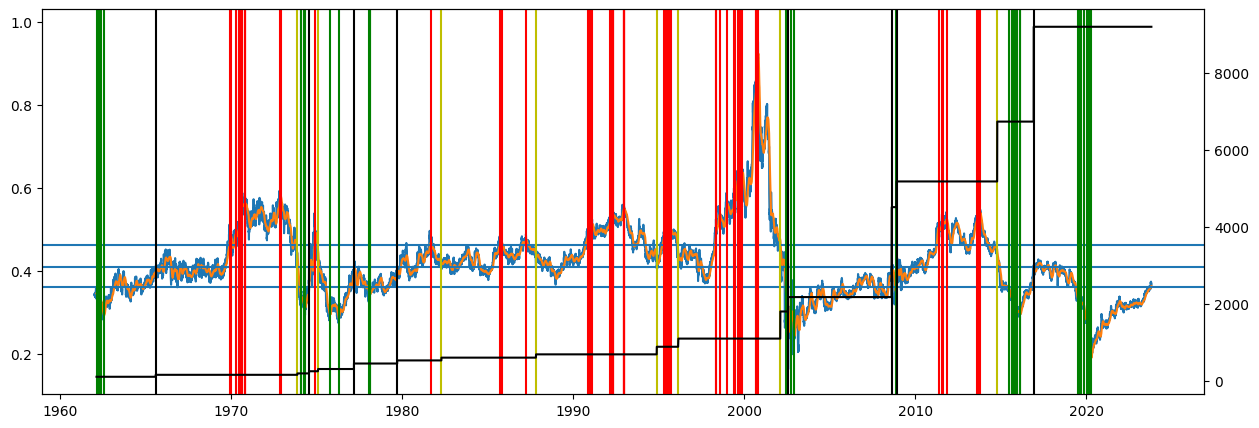

9106.957055188857


In [ ]:
Relationship=Data[['CNP','AEP']]
Relationship['ratio']=Data['CNP']/Data['AEP']
Relationship['rolling mean']=Relationship['ratio'].rolling(30).mean()
Relationship['gross return']=None
Q1=NP.quantile(Relationship['ratio'],0.25)
Q2=NP.quantile(Relationship['ratio'],0.50)
Q3=NP.quantile(Relationship['ratio'],0.75)
Figure,Axis1=PP.subplots()
Axis2=Axis1.twinx()
Figure.set_size_inches(15,5)
Axis1.plot(Relationship['ratio'])
Axis1.plot(Relationship['rolling mean'])
Axis1.axhline(Q1)
Axis1.axhline(Q2)
Axis1.axhline(Q3)
GrossReturn=1
LastSignal=(Relationship.index[0],Q2)
for Index in range(30,len(Relationship)):
  if Relationship.iloc[Index]['ratio']<Q1:
    if Relationship.iloc[Index]['ratio']<LastSignal[1]:
      if Relationship.iloc[Index]['ratio']>Relationship.iloc[Index]['rolling mean']:
        if Relationship.iloc[Index-1]['ratio']<Relationship.iloc[Index]['rolling mean']:
          PP.axvline(Relationship.index[Index],color='g')
          LastSignal=(Relationship.index[Index],Relationship.iloc[Index]['ratio'])
  elif Relationship.iloc[Index]['ratio']>Q3:
    if Relationship.iloc[Index]['ratio']>LastSignal[1]:
      if Relationship.iloc[Index]['ratio']<Relationship.iloc[Index]['rolling mean']:
        if Relationship.iloc[Index-1]['ratio']>Relationship.iloc[Index]['rolling mean']:
          PP.axvline(Relationship.index[Index],color='r')
          LastSignal=(Relationship.index[Index],Relationship.iloc[Index]['ratio'])
  if LastSignal[1]<Q2:
    if Relationship.iloc[Index]['ratio']>Q2:
      GrossReturn*=1+Relationship.iloc[Index]['CNP']/Relationship.at[LastSignal[0],'CNP']-Relationship.iloc[Index]['AEP']/Relationship.at[LastSignal[0],'AEP']
      LastSignal=(Relationship.index[Index],Q2)
      PP.axvline(Relationship.index[Index],color='k')
  elif LastSignal[1]>Q2:
    if Relationship.iloc[Index]['ratio']<Q2:
      GrossReturn*=1+Relationship.iloc[Index]['AEP']/Relationship.at[LastSignal[0],'AEP']-Relationship.iloc[Index]['CNP']/Relationship.at[LastSignal[0],'CNP']
      LastSignal=(Relationship.index[Index],Q2)
      PP.axvline(Relationship.index[Index],color='y')
  Relationship.at[Relationship.index[Index],'gross return']=GrossReturn
Axis2.plot(Relationship['gross return']*100,color='k')
PP.show()
print((GrossReturn-1)*100)